# Correlations Between Replicates

In this notebook we look into whether replicates are correlated. 

In [1]:
import pandas as pd

In [2]:
df_primary_mfi = pd.read_csv("data/primary-screen-primary-mfi.csv")
df_primary_mfi.rename(columns={"Unnamed: 0": "cell_line"}, inplace=True)

In [3]:
df_melted = df_primary_mfi.melt(id_vars=["cell_line"])
df_melted.columns = ["cell_line", "column_name", "mfi"]
df_melted.set_index("column_name", inplace=True)

In [4]:
df_melted

,cell_line,mfi
column_name,,
PREP001_X1:A01::HTS,ACH-000001,109.0
PREP001_X1:A01::HTS,ACH-000007,1146.5
PREP001_X1:A01::HTS,ACH-000008,1311.0
PREP001_X1:A01::HTS,ACH-000010_FAILED_STR,521.0
PREP001_X1:A01::HTS,ACH-000011,64.0
...,...,...
PMTS003_X3:P24::MTS004,CONTROL_BARCODE_5,NaN
PMTS003_X3:P24::MTS004,CONTROL_BARCODE_6,NaN
PMTS003_X3:P24::MTS004,CONTROL_BARCODE_7,NaN


In [5]:
df_info = pd.read_csv("data/primary-screen-replicate-treatment-info.csv")

# Focus on the experimental treatments for now
df_info = df_info[df_info.perturbation_type == "experimental_treatment"].set_index("column_name")

# Include broad_id and detection plate
df_melted = df_melted.join(df_info[["broad_id", "detection_plate"]], how="left")

# Generate a consistent cell line ordering to use later
cell_lines_ordered = df_primary_mfi[["cell_line"]].set_index("cell_line")

The following was does hastily and remains unused or tested, so there are probably bugs.

That being said, we look at the multiple detection plates for each broad_id and correlate the vectors.

In [6]:
broad_id_to_min_replicate_corr = {}

# Walk through each drug's MFI values
for broad_id, df_group in df_melted.groupby(["broad_id"]):
    detection_plate_to_replicate_vector = {}
    
    # For each drug, walk through the values for each detection plate
    for detection_plate, df_detection_group in df_group.groupby("detection_plate"):
        
        # Order the MFI values consistently and 
        single_replicate_vector = df_detection_group.set_index("cell_line").reindex(cell_lines_ordered.index)
        detection_plate_to_replicate_vector[detection_plate] = single_replicate_vector.mfi
    
    # Correlate the MFI values for each detection plate (under the same broad_id)
    df_detection_plate = pd.DataFrame(detection_plate_to_replicate_vector)
    corr = df_detection_plate.corr().stack()
    corr = corr[corr.index.get_level_values(0) != corr.index.get_level_values(1)]
    broad_id_to_min_replicate_corr[broad_id] = corr.mean()

In [7]:
df_info["min_replicate_corr"] = df_info.broad_id.apply(lambda broad_id: broad_id_to_min_replicate_corr[broad_id])

This looks somewhat reasonable: most sets of replicatse are highly correlated.

<AxesSubplot:>

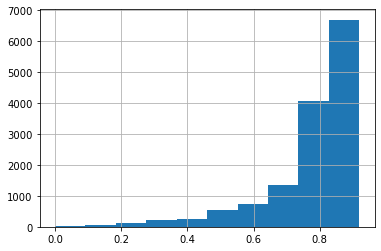

In [8]:
df_info.min_replicate_corr.hist()

In [9]:
df_info.min_replicate_corr.describe()

count    14082.000000
mean         0.771771
std          0.141032
min         -0.000661
25%          0.747502
50%          0.823292
75%          0.859748
max          0.919946
Name: min_replicate_corr, dtype: float64